In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

# preparation

In [2]:
DATA_DIR = "./data/"

In [3]:
dirs = sorted(os.listdir(DATA_DIR))
dirs = [i for i in dirs if "check" not in i]
print(dirs)

cons_dirs = ['2022-03-25', '2022-03-26', '2022-03-27', '2022-03-29', '2022-03-30', '2022-03-31']
             #'2022-04-01', '2022-04-02', '2022-04-03', '2022-04-05', '2022-04-06', '2022-04-07'

['2022-03-25', '2022-03-26', '2022-03-27', '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09', '2022-04-10']


In [4]:
for id_, folder in enumerate(cons_dirs):
    files = sorted(os.listdir(DATA_DIR + folder))
    files = [i for i in files if ".csv" in i]
    batter = pd.read_csv(DATA_DIR + folder + "/" + files[0])
    detail = pd.read_csv(DATA_DIR + folder + "/" + files[1])
    pitcher = pd.read_csv(DATA_DIR + folder + "/" + files[2])
    score = pd.read_csv(DATA_DIR + folder + "/" + files[3])

    if id_ == 0:
        print(files)
        pitcher_df = pitcher.copy()
        score_df = score.copy()
        batter_df = batter.copy()
        
        detail_df = detail.copy()
    else:
        pitcher_df = pd.concat([pitcher_df, pitcher], axis= 0)
        score_df = pd.concat([score_df, score], axis= 0)
        batter_df = pd.concat([batter_df, batter], axis= 0)

        detail_df = pd.concat([detail_df, detail], axis= 0)

pitcher_df = pitcher_df.reset_index(drop=True)
score_df = score_df.reset_index(drop=True)
batter_df = batter_df.reset_index(drop=True)
detail_df = detail_df.reset_index(drop=True)

['batter.csv', 'detail.csv', 'pitcher.csv', 'score.csv']


# analysis

In [72]:
def check_merged_data(df, col, op):
    if op == "sum":
        op_col = "合計"
    else:
        op_col = ""
    get = df.groupby(["自"]).agg({col: op}).reset_index(drop=False)
    get.columns = ["チーム", "自"+str(col)+"_"+op_col]
    give = df.groupby(["相"]).agg({col: op}).reset_index(drop=False)
    give.columns = ["チーム", "相手"+str(col)+"_"+op_col]
    no_game = df.groupby(["自"]).agg({"日付": "nunique"}).reset_index(drop=False)
    no_game.columns = ["チーム", "試合数"]
    
    data = pd.merge(get, give, on="チーム", how="left")
    data = pd.merge(data, no_game, on="チーム", how="left")
    columns = data.columns
    data[columns[1].split("_")[0]+"_平均"] = data[columns[1]] / data[columns[3]]
    data[columns[1].split("_")[0]+"_平均"] = data[columns[1].split("_")[0]+"_平均"].round(2)
    data[columns[2].split("_")[0]+"_平均"] = data[columns[2]] / data[columns[3]]
    data[columns[2].split("_")[0]+"_平均"] = data[columns[2].split("_")[0]+"_平均"].round(2)
    
    return data.sort_values("チーム").reset_index(drop=True)

In [64]:
def make_plot(df):
    cmap_keyword = "jet"
    cmap = plt.get_cmap(cmap_keyword)
    labels = df["チーム"]
    n_labels = 12
    columns = df.columns

    fig, ax = plt.subplots(figsize=(8,6))
    x_ = columns[4]
    y_ = columns[5]
    for idx, label in enumerate(labels):
        c = cmap(idx/(n_labels-3))
        ax.plot(df.iloc[idx][x_], df.iloc[idx][y_], 'bo', color=c, label=label)
        plt.annotate(label, (df[x_].values[idx], df[y_].values[idx]))
        
    mini = max(min(df[x_].min(), df[y_].min()),0)
    maxi = max(df[x_].max(), df[y_].max()) + 0.5
    x = np.linspace(mini, maxi, 100)
    ax.plot(x, x, color = "black", linestyle="dotted")
    
    plt.xlabel(x_)
    plt.ylabel(y_)
    plt.xlim(mini, maxi)
    plt.ylim(mini, maxi)
    plt.show()

## win-lose

In [7]:
pacific = ['ソフトバンク',  '楽天', '西武',  'オリックス', 'ロッテ', '日本ハム']
central = ['広島', '巨人', 'DeNA', 'ヤクルト',  '中日',  '阪神']

In [8]:
wl_table = score_df[score_df["チーム"].isin(central)].groupby("チーム")["result"].value_counts().reset_index(name="count")
wl_table = wl_table.pivot(index='チーム', columns='result', values='count').fillna(0).astype(int)
wl_table = wl_table.sort_values("W", ascending=False)
wl_table = wl_table.reindex(reversed(sorted(wl_table.columns)), axis=1)
wl_table

result,W,L
チーム,,
広島,6,0
巨人,5,1
DeNA,3,3
ヤクルト,3,3
中日,1,5
阪神,0,6


In [9]:
wl_table = score_df[score_df["チーム"].isin(pacific)].groupby("チーム")["result"].value_counts().reset_index(name="count")
wl_table = wl_table.pivot(index='チーム', columns='result', values='count').fillna(0).astype(int)
wl_table = wl_table.sort_values("W", ascending=False)
wl_table = wl_table.reindex(reversed(sorted(wl_table.columns)), axis=1)
wl_table

result,W,L
チーム,,
ソフトバンク,6,0
楽天,4,1
西武,4,2
オリックス,1,5
ロッテ,1,4
日本ハム,1,5


## batter_df

In [23]:
batter_df.head()

,位置,名,打率,打数,得点,安打,打点,三振,四球,死球,犠打,盗塁,失策,本塁打,自,相,H/V,日付,ID
0,中,塩見 泰隆,.400,5,1,2,1,2,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0
1,左,青木 宣親,.000,4,0,0,0,0,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0
2,投,坂本 光士郎,-,0,0,0,0,0,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0
3,指,川端 慎吾,.000,1,0,0,0,0,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0
4,投,梅野 雄吾,-,0,0,0,0,0,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0


,チーム,自打数_合計,相手打数_合計,試合数,自打数_平均,相手打数_平均
0,オリ,188,192,6,31.33,32.00
1,中日,201,198,6,33.50,33.00
2,北海,188,193,6,31.33,32.17
3,千葉,172,168,5,34.40,33.60
4,埼玉,192,189,6,32.00,31.50
5,広島,208,211,6,34.67,35.17
6,東京,203,200,6,33.83,33.33
7,東北,170,169,5,34.00,33.80
8,横浜,203,208,6,33.83,34.67
9,福岡,191,190,6,31.83,31.67


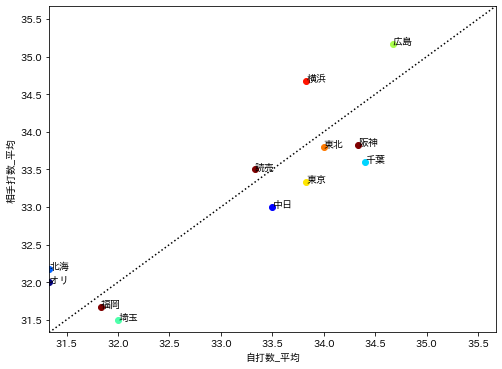

In [73]:
merged_box = check_merged_data(batter_df, "打数", "sum")
display(merged_box)
make_plot(merged_box)

,チーム,自安打_合計,相手安打_合計,試合数,自安打_平均,相手安打_平均
0,オリ,33,44,6,5.50,7.33
1,中日,43,53,6,7.17,8.83
2,北海,36,48,6,6.00,8.00
3,千葉,33,36,5,6.60,7.20
4,埼玉,45,37,6,7.50,6.17
5,広島,68,52,6,11.33,8.67
6,東京,51,42,6,8.50,7.00
7,東北,35,34,5,7.00,6.80
8,横浜,48,58,6,8.00,9.67
9,福岡,48,31,6,8.00,5.17


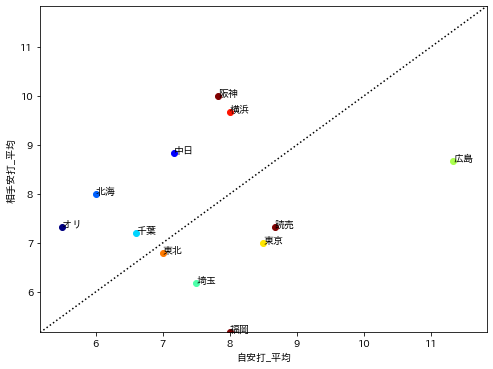

In [74]:
merged_hit = check_merged_data(batter_df, "安打", "sum")
display(merged_hit)
make_plot(merged_hit)

,チーム,自得点_合計,相手得点_合計,試合数,自得点_平均,相手得点_平均
0,オリ,14,21,6,2.33,3.50
1,中日,20,28,6,3.33,4.67
2,北海,17,27,6,2.83,4.50
3,千葉,14,15,5,2.80,3.00
4,埼玉,23,21,6,3.83,3.50
5,広島,42,21,6,7.00,3.50
6,東京,27,22,6,4.50,3.67
7,東北,15,11,5,3.00,2.20
8,横浜,26,34,6,4.33,5.67
9,福岡,25,13,6,4.17,2.17


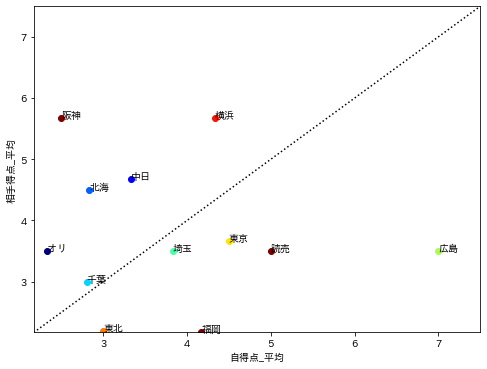

In [75]:
merged_score = check_merged_data(batter_df, "得点", "sum")
display(merged_score)
make_plot(merged_score)

## pitcher

In [76]:
pitcher_df.head()

,位,選手名,防御率,投球回,投球数,打者,被安打,被本塁打,奪三振,与四球,与死球,ボーク,失点,自責点,自,相,H/V,日付,ID
0,先発,小川 泰弘,12,3.0,80,18,11,0,2,0,0,0,4,4,東京,阪神,V,2022-03-25,0
1,中継,大下 佑馬,3,3.0,45,13,3,1,5,0,0,0,4,1,東京,阪神,V,2022-03-25,0
2,中継,坂本 光士郎,0,1.0,26,4,0,0,1,1,0,0,0,0,東京,阪神,V,2022-03-25,0
3,中継,梅野 雄吾,0,1.0,11,3,0,0,0,0,0,0,0,0,東京,阪神,V,2022-03-25,0
4,中継,マクガフ,0,1.0,19,5,1,0,0,1,0,0,0,0,東京,阪神,V,2022-03-25,0


,チーム,自登板投手数,相手登板投手数,試合数,自投球数_平均,相手投球数_平均
0,オリ,22,24,6,3.67,4.00
1,中日,27,26,6,4.50,4.33
2,北海,29,26,6,4.83,4.33
3,千葉,23,24,5,4.60,4.80
4,埼玉,25,22,6,4.17,3.67
5,広島,23,26,6,3.83,4.33
6,東京,24,29,6,4.00,4.83
7,東北,23,21,5,4.60,4.20
8,横浜,23,24,6,3.83,4.00
9,福岡,26,31,6,4.33,5.17


|    | チーム   |   自登板投手数 |   相手登板投手数 |   試合数 |   自投球数_平均 |   相手投球数_平均 |
|---:|:---------|---------------:|-----------------:|---------:|----------------:|------------------:|
|  0 | オリ     |             22 |               24 |        6 |            3.67 |              4    |
|  1 | 中日     |             27 |               26 |        6 |            4.5  |              4.33 |
|  2 | 北海     |             29 |               26 |        6 |            4.83 |              4.33 |
|  3 | 千葉     |             23 |               24 |        5 |            4.6  |              4.8  |
|  4 | 埼玉     |             25 |               22 |        6 |            4.17 |              3.67 |
|  5 | 広島     |             23 |               26 |        6 |            3.83 |              4.33 |
|  6 | 東京     |             24 |               29 |        6 |            4    |              4.83 |
|  7 | 東北     |             23 |               21 |        5 |            4.6  |              4.2  |
|  8 | 横浜     |   

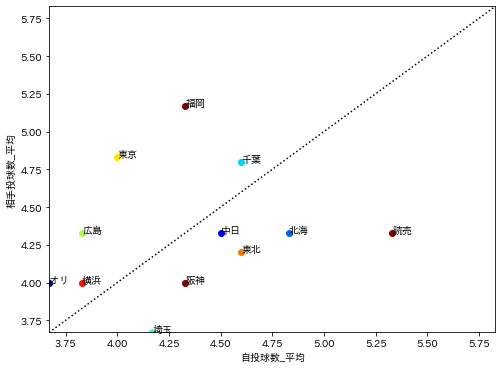

In [89]:
merged_pitcher_num = check_merged_data(pitcher_df, "投球数", "count")
merged_pitcher_num = merged_pitcher_num.rename(columns = {"自投球数_": "自登板投手数",
                                                                                                                     "相手投球数_": "相手登板投手数"})
display(merged_pitcher_num)
print(merged_pitcher_num.to_markdown())
make_plot(merged_pitcher_num)

,チーム,自投球数_合計,相手投球数_合計,試合数,自投球数_平均,相手投球数_平均
0,オリ,862,829,6,143.67,138.17
1,中日,915,863,6,152.50,143.83
2,北海,862,843,6,143.67,140.50
3,千葉,782,786,5,156.40,157.20
4,埼玉,848,831,6,141.33,138.50
5,広島,808,893,6,134.67,148.83
6,東京,856,932,6,142.67,155.33
7,東北,747,760,5,149.40,152.00
8,横浜,844,876,6,140.67,146.00
9,福岡,863,915,6,143.83,152.50


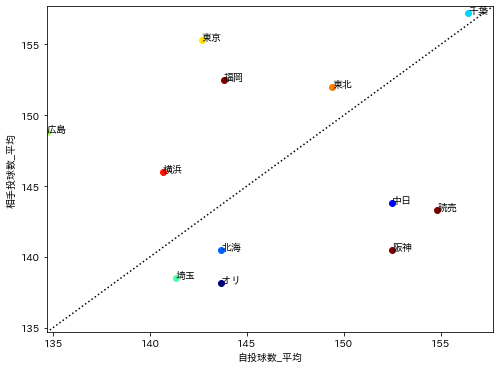

In [78]:
merged_pitch = check_merged_data(pitcher_df, "投球数", "sum")
display(merged_pitch)
make_plot(merged_pitch)

,チーム,自奪三振_合計,相手奪三振_合計,試合数,自奪三振_平均,相手奪三振_平均
0,オリ,48,40,6,8.00,6.67
1,中日,35,35,6,5.83,5.83
2,北海,44,51,6,7.33,8.50
3,千葉,41,45,5,8.20,9.00
4,埼玉,41,46,6,6.83,7.67
5,広島,38,25,6,6.33,4.17
6,東京,40,59,6,6.67,9.83
7,東北,34,47,5,6.80,9.40
8,横浜,27,41,6,4.50,6.83
9,福岡,61,40,6,10.17,6.67


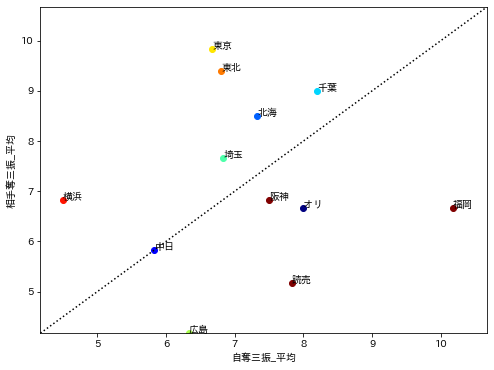

In [79]:
merged_pitch = check_merged_data(pitcher_df, "奪三振", "sum")
display(merged_pitch)
make_plot(merged_pitch)

,チーム,自対戦打者_合計,相手対戦打者_合計,試合数,自打者_平均,相手打者_平均
0,オリ,217,211,6,36.17,35.17
1,中日,232,227,6,38.67,37.83
2,北海,222,212,6,37.00,35.33
3,千葉,193,195,5,38.60,39.00
4,埼玉,213,209,6,35.50,34.83
5,広島,227,237,6,37.83,39.50
6,東京,228,228,6,38.00,38.00
7,東北,192,194,5,38.40,38.80
8,横浜,233,232,6,38.83,38.67
9,福岡,213,229,6,35.50,38.17


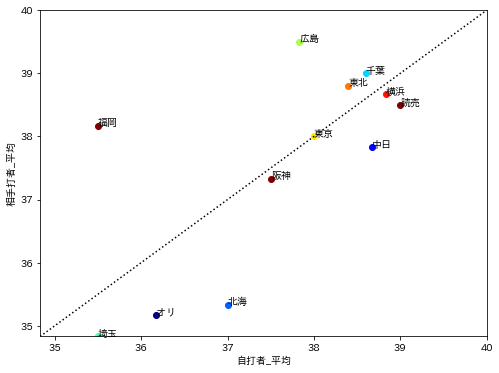

In [80]:
merged_enem_batter = check_merged_data(pitcher_df, "打者", "sum")
merged_enem_batter = merged_enem_batter.rename(columns = {"自打者_合計": "自対戦打者_合計",
                                                                                                                     "相手打者_合計": "相手対戦打者_合計"})
display(merged_enem_batter)
make_plot(merged_enem_batter)

,チーム,自奪三振_合計,相手奪三振_合計,試合数,自奪三振_平均,相手奪三振_平均
0,オリ,48,40,6,8.00,6.67
1,中日,35,35,6,5.83,5.83
2,北海,44,51,6,7.33,8.50
3,千葉,41,45,5,8.20,9.00
4,埼玉,41,46,6,6.83,7.67
5,広島,38,25,6,6.33,4.17
6,東京,40,59,6,6.67,9.83
7,東北,34,47,5,6.80,9.40
8,横浜,27,41,6,4.50,6.83
9,福岡,61,40,6,10.17,6.67


|    | チーム   |   自奪三振_合計 |   相手奪三振_合計 |   試合数 |   自奪三振_平均 |   相手奪三振_平均 |
|---:|:---------|----------------:|------------------:|---------:|----------------:|------------------:|
|  0 | オリ     |              48 |                40 |        6 |            8    |              6.67 |
|  1 | 中日     |              35 |                35 |        6 |            5.83 |              5.83 |
|  2 | 北海     |              44 |                51 |        6 |            7.33 |              8.5  |
|  3 | 千葉     |              41 |                45 |        5 |            8.2  |              9    |
|  4 | 埼玉     |              41 |                46 |        6 |            6.83 |              7.67 |
|  5 | 広島     |              38 |                25 |        6 |            6.33 |              4.17 |
|  6 | 東京     |              40 |                59 |        6 |            6.67 |              9.83 |
|  7 | 東北     |              34 |                47 |        5 |            6.8  |              9.4  

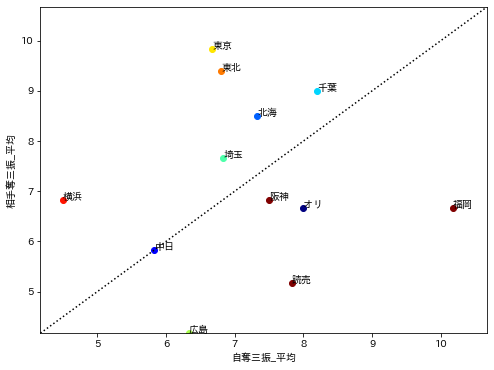

In [87]:
merged_struck_out = check_merged_data(pitcher_df, "奪三振", "sum")
display(merged_struck_out)
print(merged_struck_out.to_markdown())
make_plot(merged_struck_out)

,チーム,自被本塁打_合計,相手被本塁打_合計,試合数,自被本塁打_平均,相手被本塁打_平均
0,オリ,3,1,6,0.50,0.17
1,中日,4,4,6,0.67,0.67
2,北海,5,6,6,0.83,1.00
3,千葉,0,2,5,0.00,0.40
4,埼玉,2,4,6,0.33,0.67
5,広島,4,1,6,0.67,0.17
6,東京,4,8,6,0.67,1.33
7,東北,1,1,5,0.20,0.20
8,横浜,2,4,6,0.33,0.67
9,福岡,6,3,6,1.00,0.50


|    | チーム   |   自被本塁打_合計 |   相手被本塁打_合計 |   試合数 |   自被本塁打_平均 |   相手被本塁打_平均 |
|---:|:---------|------------------:|--------------------:|---------:|------------------:|--------------------:|
|  0 | オリ     |                 3 |                   1 |        6 |              0.5  |                0.17 |
|  1 | 中日     |                 4 |                   4 |        6 |              0.67 |                0.67 |
|  2 | 北海     |                 5 |                   6 |        6 |              0.83 |                1    |
|  3 | 千葉     |                 0 |                   2 |        5 |              0    |                0.4  |
|  4 | 埼玉     |                 2 |                   4 |        6 |              0.33 |                0.67 |
|  5 | 広島     |                 4 |                   1 |        6 |              0.67 |                0.17 |
|  6 | 東京     |                 4 |                   8 |        6 |              0.67 |                1.33 |
|  7 | 東北     |                 1

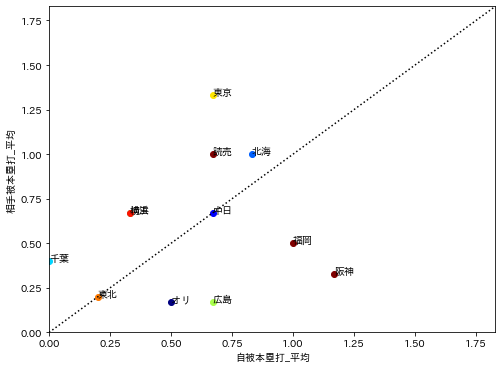

In [88]:
merged_pitch = check_merged_data(pitcher_df, "被本塁打", "sum")
display(merged_pitch)
print(merged_pitch.to_markdown())
make_plot(merged_pitch)